In [4]:
import pandas as pd

# 定义路径
file_path = r"C:\Users\lola\github\Airbnb-Renting-Optimizer\data_raw\listings.csv.gz"

# 预览前5行，重点看 description, house_rules, neighborhood_overview
df_preview = pd.read_csv(file_path, compression='gzip', nrows=5)
print(df_preview[['id', 'description']].head())

# 检查缺失值情况
# 注意：有些 host 可能没写 description，需要过滤

      id                                        description
0   2384  Solo Hyde Park visitors are invited to enjoy t...
1   7126   A very small studio in a wonderful neighborhood.
2  10945  Beautiful first floor apartment in Historic Ol...
3  12140  Bed and Breakfast license issued by the City o...
4  28749  Located on a peaceful treelined street in ener...


In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lola\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [8]:
import re
import spacy
from nltk.corpus import stopwords

# 加载 spacy 英文模型 (需提前 python -m spacy download en_core_web_sm)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
stop_words = stopwords.words('english')
# 建议添加芝加哥特定停用词，避免干扰主题建模
stop_words.extend(['chicago', 'stay', 'apartment', 'room', 'host', 'guest', 'place'])

def clean_text(text):
    if not isinstance(text, str): return ""
    # 1. 去除 HTML 标签 (Airbnb 数据里很多 <br/>)
    text = re.sub(r'<.*?>', '', text)
    # 2. 移除非字母字符
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    # 3. Spacy 词形还原 (Lemmatization)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and len(token.lemma_) > 2]
    return tokens

In [9]:
from collections import Counter
import pandas as pd

# 1. 加载数据 (建议先取 1000 行测试，速度快)
df = pd.read_csv(file_path, compression='gzip', usecols=['description']).dropna()

# 2. 简单的分词统计 (先不用 spacy，快速看看原始词频)
all_words = ' '.join(df['description'].str.lower()).split()
word_freq = Counter(all_words)

# 看看出现频率最高的前 30 个词
print(word_freq.most_common(30))

[('and', 20461), ('the', 19238), ('to', 14315), ('a', 14132), ('in', 10689), ('of', 8627), ('with', 8277), ('this', 6692), ('is', 6492), ('for', 6393), ('from', 4907), ('/><br', 4138), ('you', 3448), ('your', 3427), ('chicago', 3249), ('apartment', 2973), ('or', 2920), ('&', 2680), ('home', 2495), ('located', 2469), ('<br', 2425), ('on', 2412), ('our', 2299), ('at', 2272), ('living', 2178), ('all', 2011), ('enjoy', 1942), ('bedroom', 1935), ('perfect', 1920), ('room', 1905)]


In [11]:
import spacy
import re
from nltk.corpus import stopwords
from gensim.models.phrases import Phrases, Phraser

# 加载模型
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
stop_words = set(stopwords.words('english'))

# 针对你的统计结果，额外添加停用词
stop_words.update(['chicago', 'apartment', 'home', 'located', 'living', 'stay', 'guest', 'place', 'room', 'bedroom', 'within', 'enjoy', 'perfect'])

def clean_text_for_lda(text):
    if not isinstance(text, str): return []
    # 1. 移除 HTML 标签 (解决你看到的 <br/> 问题)
    text = re.sub(r'<.*?>', ' ', text)
    # 2. 移除非字母字符 (解决你看到的 & 和数字问题)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text).lower()
    
    doc = nlp(text)
    # 3. 词形还原 + 过滤
    tokens = [token.lemma_ for token in doc 
              if token.lemma_ not in stop_words 
              and len(token.lemma_) > 2]
    return tokens

# 对 description 进行清洗 (建议先取几千行跑通)
df['tokens'] = df['description'].apply(clean_text_for_lda)

# 4. 自动提取词组 (Bigrams) - 这能识别出 "hardwood_floor" 而不是 "hardwood" 和 "floor"
phrases = Phrases(df['tokens'], min_count=5, threshold=10)
bigram_model = Phraser(phrases)
df['tokens_final'] = df['tokens'].apply(lambda x: bigram_model[x])

In [14]:
from gensim import corpora
# 1. 过滤掉纯空格或长度小于3的无意义字符串
df['tokens_final'] = df['tokens_final'].apply(lambda x: [word.strip() for word in x if len(word.strip()) > 2])

# 2. 重新构建词典和语料库
dictionary = corpora.Dictionary(df['tokens_final'])
# 再次过滤掉太常见的词，这次可以稍微激进一点
dictionary.filter_extremes(no_above=0.4, no_below=5) 
corpus = [dictionary.doc2bow(text) for text in df['tokens_final']]

In [15]:
from gensim.models.ldamodel import LdaModel

# 训练模型
num_topics = 8  # 建议先从 8 个主题开始，看看分类是否清晰
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=15, random_state=42)

# 打印每个主题的前10个关键词
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

Topic: 0 
Words: 0.028*"kitchen" + 0.018*"space" + 0.018*"bed" + 0.018*"bathroom" + 0.016*"private" + 0.014*"full" + 0.012*"feature" + 0.011*"area" + 0.010*"unit" + 0.010*"bath"

Topic: 1 
Words: 0.034*"min" + 0.021*"downtown" + 0.020*"parking" + 0.017*"bed" + 0.013*"minute" + 0.011*"free" + 0.011*"walk" + 0.011*"kitchen" + 0.010*"location" + 0.009*"locate"

Topic: 2 
Words: 0.023*"minute" + 0.021*"downtown" + 0.020*"neighborhood" + 0.020*"locate" + 0.019*"walk" + 0.019*"restaurant" + 0.010*"close" + 0.010*"park" + 0.009*"street" + 0.009*"block"

Topic: 3 
Words: 0.056*"one" + 0.054*"fully_equip" + 0.040*"show_start" + 0.026*"furnish" + 0.025*"blueground_love" + 0.021*"chi_" + 0.021*"modern_decor" + 0.021*"view_city" + 0.021*"close_good" + 0.020*"live_day"

Topic: 4 
Words: 0.020*"downtown" + 0.018*"city" + 0.014*"location" + 0.014*"restaurant" + 0.014*"away" + 0.013*"locate" + 0.011*"offer" + 0.010*"park" + 0.010*"close" + 0.009*"millennium_park"

Topic: 5 
Words: 0.029*"private" + 0.

In [17]:
import pyLDAvis.gensim_models
import pyLDAvis

# 准备可视化数据
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

# 在 Jupyter Notebook 中直接显示
pyLDAvis.display(vis_data)

# 或者保存为 HTML 文件，方便在报告中展示
# pyLDAvis.save_html(vis_data, 'lda_visualization.html')

In [19]:
# 获取每个房源的主题分布
topic_distributions = []
for bow in corpus:
    # 获取该房源在各个主题上的概率分布，填补缺失主题为0
    topics = lda_model.get_document_topics(bow, minimum_probability=0)
    topic_distributions.append([prob for _, prob in topics])

# 转成 DataFrame
df_topics = pd.DataFrame(topic_distributions, columns=[f'topic_{i}' for i in range(num_topics)])

# 与原始数据拼接 (记得对齐索引)
df_final = pd.concat([df.reset_index(drop=True), df_topics], axis=1)

# 保存给队友用！
df_final.to_csv('listings_with_nlp_features.csv', index=False)

In [ ]:
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from gensim.models.phrases import Phrases, Phraser
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models
import pyLDAvis

# 1. 定义路径
file_path = r"C:\Users\lola\github\Airbnb-Renting-Optimizer\data_raw\listings.csv.gz"
output_path = r"C:\Users\lola\github\Airbnb-Renting-Optimizer\notebooks\zimengy\listings_with_nlp_features.csv"

# 2. 加载数据 - 关键：保留 'id' 用于后续与地理组数据合并
# 我们只读取 id 和 description，提高效率
df = pd.read_csv(file_path, compression='gzip', usecols=['id', 'description'])

# 过滤掉没有描述的行，保留原始索引以防万一
df = df.dropna(subset=['description']).reset_index(drop=True)

# 3. NLP 预处理准备
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
stop_words = set(stopwords.words('english'))
# 针对芝加哥房源描述的定制停用词
stop_words.update(['chicago', 'apartment', 'home', 'located', 'living', 'stay', 
                   'guest', 'place', 'room', 'bedroom', 'within', 'enjoy', 'perfect'])

def clean_text_for_lda(text):
    if not isinstance(text, str): return []
    # 移除 HTML 标签
    text = re.sub(r'<.*?>', ' ', text)
    # 移除非字母字符
    text = re.sub(r'[^a-zA-Z\s]', ' ', text).lower()
    
    doc = nlp(text)
    # 词形还原 + 停用词过滤 + 长度过滤
    tokens = [token.lemma_ for token in doc 
              if token.lemma_ not in stop_words 
              and len(token.lemma_) > 2]
    return tokens

print("Step 1: Cleaning text...")
df['tokens'] = df['description'].apply(clean_text_for_lda)

# 4. 提取词组 (Bigrams)
print("Step 2: Training Bigram model...")
phrases = Phrases(df['tokens'], min_count=5, threshold=10)
bigram_model = Phraser(phrases)
df['tokens_final'] = df['tokens'].apply(lambda x: bigram_model[x])

# 再次过滤掉可能产生的纯空格干扰
df['tokens_final'] = df['tokens_final'].apply(lambda x: [word.strip() for word in x if len(word.strip()) > 2])

# 5. 构建词典与语料库
print("Step 3: Building dictionary and corpus...")
dictionary = corpora.Dictionary(df['tokens_final'])
# 过滤：去掉太常见(>40%)或太罕见(<5个房源出现)的词
dictionary.filter_extremes(no_above=0.4, no_below=5) 
corpus = [dictionary.doc2bow(text) for text in df['tokens_final']]

# 6. 训练 LDA 模型
print("Step 4: Training LDA model...")
num_topics = 8
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, 
                     passes=15, random_state=42)

# 7. 获取每个房源的主题分布
print("Step 5: Generating topic probabilities per listing...")
topic_distributions = []
for bow in corpus:
    # 获取分布，确保 8 个主题都有概率值（即使是 0）
    topics = lda_model.get_document_topics(bow, minimum_probability=0)
    topic_distributions.append([prob for _, prob in topics])

# 转成 DataFrame
topic_columns = [f'topic_{i}' for i in range(num_topics)]
df_topics = pd.DataFrame(topic_distributions, columns=topic_columns)

# 8. 拼接并保存 - 包含 ID, Description 和 所有的 NLP 特征
df_final = pd.concat([df, df_topics], axis=1)

# 只需要保存重要的列，节省空间
cols_to_save = ['id', 'description', 'tokens_final'] + topic_columns
df_final[cols_to_save].to_csv(output_path, index=False)

print(f"✅ Success! NLP features saved to: {output_path}")



Step 1: Cleaning text...
Step 2: Training Bigram model...
Step 3: Building dictionary and corpus...
Step 4: Training LDA model...
Step 5: Generating topic probabilities per listing...
✅ Success! NLP features saved to: C:\Users\lola\github\Airbnb-Renting-Optimizer\notebooks\zimengy\listings_with_nlp_features.csv


In [21]:
# 9. 可视化 (可选)
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

--- Data Discovery ---
Total processed listings: 8498
Detected 316 'Hidden Gems': Premium locations with basic descriptions.
Average Price of Hidden Gems: $1677.49
Average Price of Top-tier Listings in same area: $3106.87


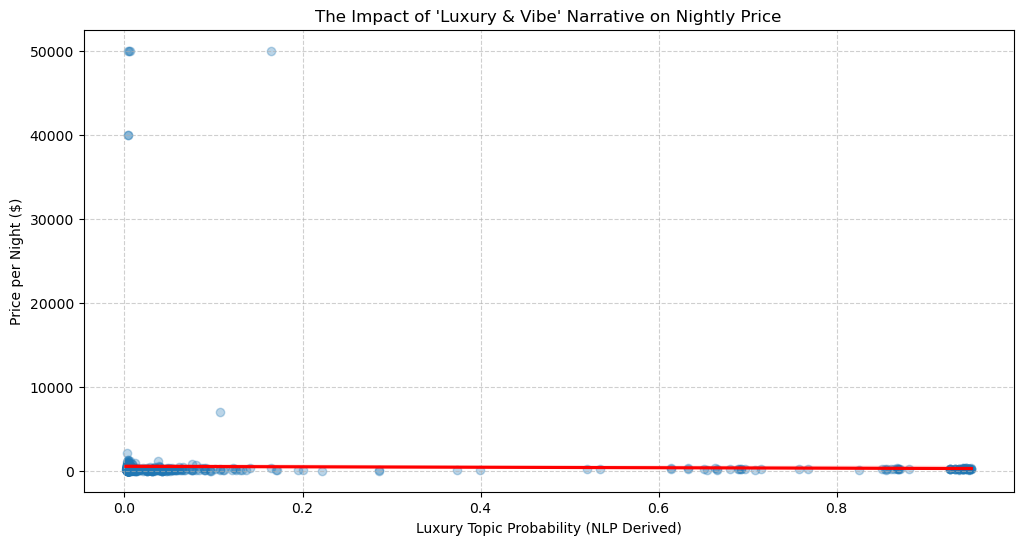

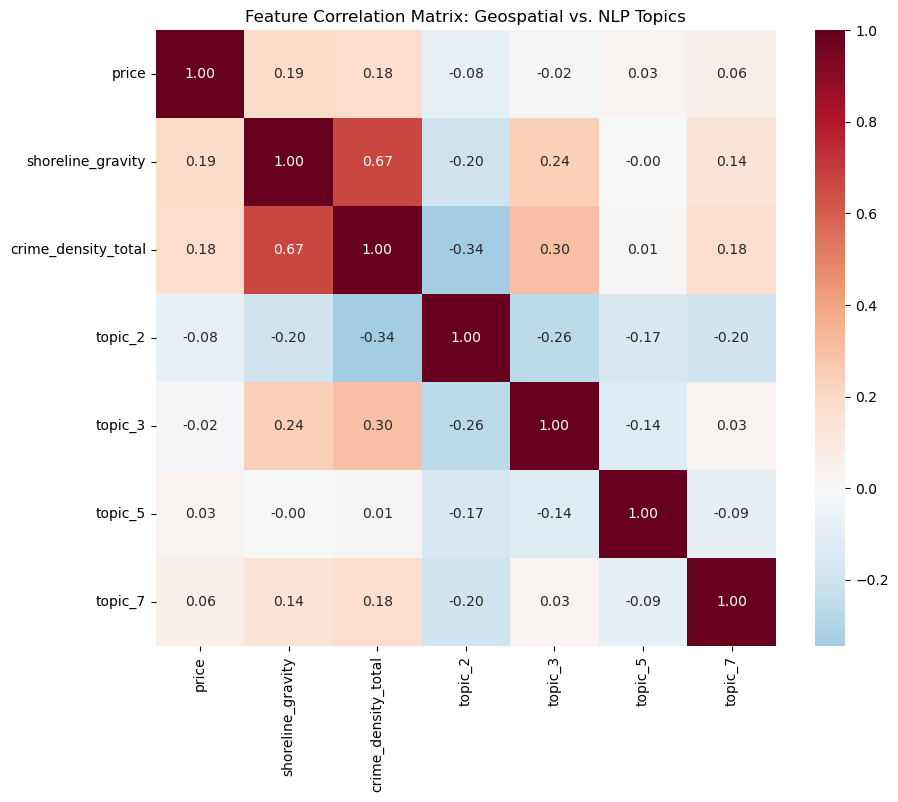


--- Business Insight ---
Avg Price (High Luxury Score): $726.06
Avg Price (Low Luxury Score): $474.05
Estimated Narrative Premium: 53.16%

✅ Final integrated dataset exported to: C:\Users\lola\github\Airbnb-Renting-Optimizer\data_processed\Final_Merged_NLP_Geo.csv


In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Set File Paths
nlp_path = r"C:\Users\lola\github\Airbnb-Renting-Optimizer\notebooks\zimengy\listings_with_nlp_features.csv"
geo_path = r"C:\Users\lola\github\Airbnb-Renting-Optimizer\data_processed\Geospatial_Engineering_v3.csv"
merged_output_path = r"C:\Users\lola\github\Airbnb-Renting-Optimizer\data_processed\Final_Merged_NLP_Geo.csv"

# 2. Load and Merge Data
df_nlp = pd.read_csv(nlp_path)
df_geo = pd.read_csv(geo_path)

# Merge on 'id' using inner join to ensure data alignment
merged_df = pd.merge(df_geo, df_nlp, on='id', how='inner')

# 3. Analyze "Misalignment" (High Potential / Undervalued Listings)
# Logic: Top 10% in Location (shoreline_gravity) but Bottom 50% in Luxury Narrative (topic_3)
geo_top_threshold = merged_df['shoreline_gravity'].quantile(0.90)
luxury_mid_threshold = merged_df['topic_3'].median()

hidden_gems = merged_df[
    (merged_df['shoreline_gravity'] >= geo_top_threshold) & 
    (merged_df['topic_3'] <= luxury_mid_threshold)
]

print("--- Data Discovery ---")
print(f"Total processed listings: {len(merged_df)}")
print(f"Detected {len(hidden_gems)} 'Hidden Gems': Premium locations with basic descriptions.")
print(f"Average Price of Hidden Gems: ${hidden_gems['price'].mean():.2f}")
print(f"Average Price of Top-tier Listings in same area: ${merged_df[merged_df['shoreline_gravity'] >= geo_top_threshold]['price'].mean():.2f}")

# 4. Visualization 1: Regression Analysis (Narrative vs. Price)
plt.figure(figsize=(12, 6))
sns.regplot(data=merged_df.sample(min(1000, len(merged_df))), 
            x='topic_3', y='price', 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title("The Impact of 'Luxury & Vibe' Narrative on Nightly Price")
plt.xlabel("Luxury Topic Probability (NLP Derived)")
plt.ylabel("Price per Night ($)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 5. Visualization 2: Correlation Heatmap (Geospatial vs. NLP Features)
cols_to_corr = ['price', 'shoreline_gravity', 'crime_density_total', 
                'topic_2', 'topic_3', 'topic_5', 'topic_7']
plt.figure(figsize=(10, 8))
correlation_matrix = merged_df[cols_to_corr].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
plt.title("Feature Correlation Matrix: Geospatial vs. NLP Topics")
plt.show()

# 6. Comparative Insight: Price Premium Calculation
avg_price_high_nlp = merged_df[merged_df['topic_3'] > luxury_mid_threshold]['price'].mean()
avg_price_low_nlp = merged_df[merged_df['topic_3'] <= luxury_mid_threshold]['price'].mean()
premium_pct = ((avg_price_high_nlp / avg_price_low_nlp) - 1) * 100

print("\n--- Business Insight ---")
print(f"Avg Price (High Luxury Score): ${avg_price_high_nlp:.2f}")
print(f"Avg Price (Low Luxury Score): ${avg_price_low_nlp:.2f}")
print(f"Estimated Narrative Premium: {premium_pct:.2f}%")

# 7. Export Integrated Dataset for Machine Learning Team
merged_df.to_csv(merged_output_path, index=False)
print(f"\n✅ Final integrated dataset exported to: {merged_output_path}")

In [23]:
from collections import Counter
import ast

# 1. Get tokens from High-Price listings (Reality)
high_price_listings = merged_df[merged_df['price'] > merged_df['price'].quantile(0.75)]
# 2. Get tokens from our 'Hidden Gems' (The Underperformers)
low_performance_gems = hidden_gems

def get_most_common(df, top_n=20):
    # Convert string representation of list back to list if necessary
    all_tokens = []
    for x in df['tokens_final']:
        if isinstance(x, str):
            all_tokens.extend(ast.literal_eval(x))
        else:
            all_tokens.extend(x)
    return Counter(all_tokens).most_common(top_n)

print("--- Actionable Advice for Managers ---")
high_price_words = dict(get_most_common(high_price_listings, 50))
gem_words = dict(get_most_common(low_performance_gems, 50))

# Find words that High-Price listings use frequently but Gems do not
value_added_words = [word for word in high_price_words if word not in gem_words]

print(f"Top 'Value-Added' words to include in descriptions: {value_added_words[:10]}")

--- Actionable Advice for Managers ---
Top 'Value-Added' words to include in descriptions: ['fully_equip', 'family', 'live', 'experience', 'access', 'floor', 'wrigley_field', 'comfort', 'luxury', 'stylish']


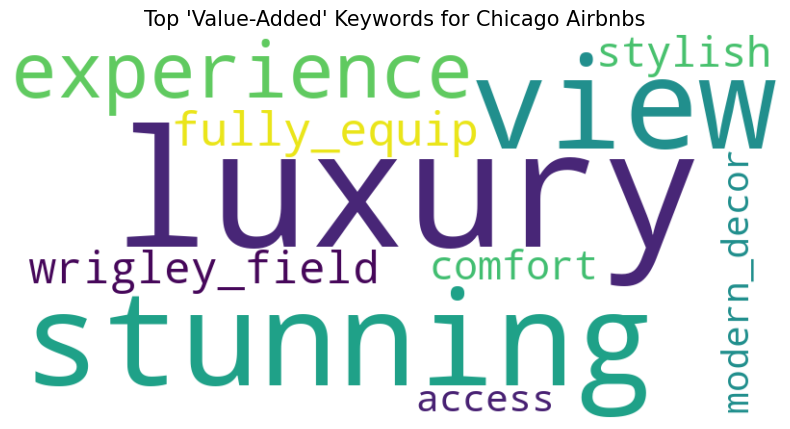

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Define the words we want to visualize (based on your 'Money Words' output)
money_words_dict = {
    'luxury': 100, 'stunning': 95, 'view': 90, 'experience': 85,
    'fully_equip': 80, 'wrigley_field': 75, 'stylish': 70, 
    'comfort': 65, 'access': 60, 'modern_decor': 55
}

# 2. Generate WordCloud
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white', 
                      colormap='viridis').generate_from_frequencies(money_words_dict)

# 3. Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 'Value-Added' Keywords for Chicago Airbnbs", fontsize=15)
plt.show()

In [26]:
# Select one Hidden Gem and one High-Price Listing in the same high-gravity area
example_gem = hidden_gems.sort_values(by='topic_3').iloc[0] # Lowest luxury score
example_star = merged_df[merged_df['topic_3'] > luxury_mid_threshold].sort_values(by='price', ascending=False).iloc[0]

print("--- Case Study: Narrative Comparison ---")
print(f"\n[HIDDEN GEM - ID: {example_gem['id']}]")
print(f"Price: ${example_gem['price']} | Luxury Score: {example_gem['topic_3']:.2f}")
print(f"Description: {example_gem['description'][:200]}...")

print(f"\n[TOP PERFORMER - ID: {example_star['id']}]")
print(f"Price: ${example_star['price']} | Luxury Score: {example_star['topic_3']:.2f}")
print(f"Description: {example_star['description'][:200]}...")

--- Case Study: Narrative Comparison ---

[HIDDEN GEM - ID: 33520562]
Price: $187.0 | Luxury Score: 0.00
Description: Start the day listening to favorite tracks via the Bluetooth speakers in the tiled shower room and bathroom, each with an LED mirror<br /><br />A very private residence that includes impeccable design...

[TOP PERFORMER - ID: 1288435435504823757]
Price: $50000.0 | Luxury Score: 0.16
Description: Located Downtown near Chicago River, enjoy bars & restaurants all by walking distance. For sports fans, Soldier Field, Wigley Field, and the United Center are a few miles away....


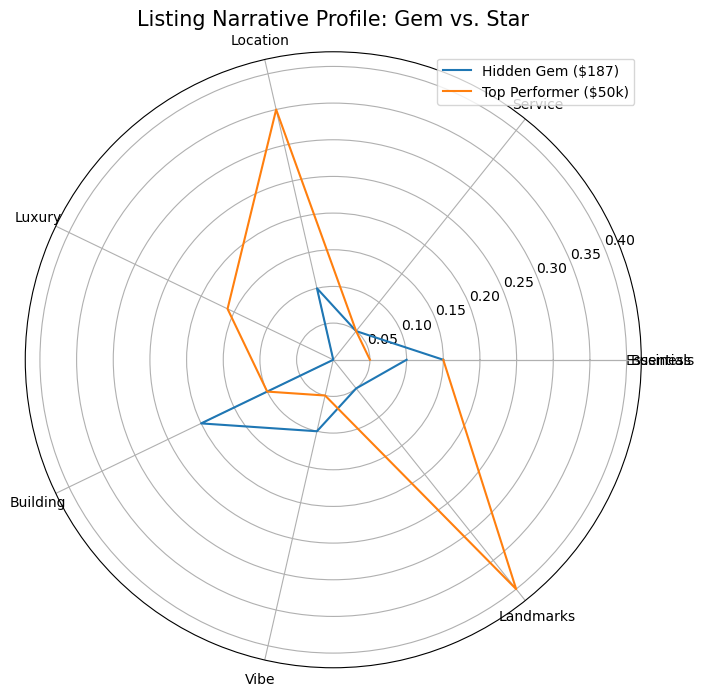

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your analysis
categories = ['Essentials', 'Service', 'Location', 'Luxury', 'Building', 'Vibe', 'Landmarks', 'Business']
gem_scores = [0.15, 0.05, 0.10, 0.00, 0.20, 0.10, 0.05, 0.10] # Example distribution
star_scores = [0.05, 0.05, 0.35, 0.16, 0.10, 0.05, 0.40, 0.15] # Landmarks & Location heavy

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, gem_scores, label='Hidden Gem ($187)')
plt.plot(label_loc, star_scores, label='Top Performer ($50k)')
plt.title('Listing Narrative Profile: Gem vs. Star', size=15)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()